In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr  
from spglm.family import Gaussian
np.set_printoptions(precision=3, suppress=True)

In [3]:
# Simulate S1 and S2
def simulate_S1_S2(num_points1, num_points2):
    np.random.seed(26)
    locations1 = np.random.rand(num_points1, 2) * 100
    centers = [(30, 30), (70, 70), (30, 70), (70, 30)]
    locations2, _ = make_blobs(n_samples=num_points2, centers=centers, cluster_std=10.0, random_state=26)
    locations2 = np.clip(locations2, 0, 100)
    s1 = np.random.normal(50, 20, num_points1)
    s2 = np.random.normal(100, 50, num_points2)
    return s1, locations1, s2, locations2

S1, loc1, S2, loc2 = simulate_S1_S2(200, 350)

# Create beta surface
def create_beta_surface(locations, complexity='uniform'):
    x, y = locations[:, 0], locations[:, 1]
    if complexity == 'uniform':
        B = x / 10 + y / 10
    elif complexity == 'local':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B

# Define true beta surface
B = create_beta_surface(loc1, complexity='uniform')

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=35).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [4]:
# Gaussian family initialization
family = Gaussian()

In [5]:
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc

def log_likelihood_gaussian(residuals, n):
    """Calculate log-likelihood for Gaussian model."""
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood

In [15]:
trace = []
def perform_local_regression_using_betas_gwr(n_neighbor_est, loc1, loc2, S2, y):
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))
    tr_S = 0  # To accumulate trace of the hat matrix

    for i in range(len(S1)):
        # Find neighbors in S2 for current S1_i for smoothing
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        local_X = []
        weights_X = []
        
        # Smooth S2 onto S1 within the local regression function
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Local regression using weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]].reshape(-1, 1)
        X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

        weights_y = np.exp(-0.5 * (distances[0] / 10)**2).reshape(-1, 1)
        W_y = np.sqrt(weights_y)  # These weights will be used in _compute_betas_gwr routine

        # Use _compute_betas_gwr
        betas, xtx_inv_xt = _compute_betas_gwr(y_neighbors, X_neighbors, W_y)

        recovered_betas[i] = betas[0].item()  

        # Calculate residuals
        y_pred = X_neighbors @ betas.reshape(-1, 1)  # Ensure betas is shaped correctly for multiplication
        residuals[i] = np.sum((y_neighbors - y_pred)**2)

        # Influence calculation 
        # xtx_inv_xt should have compatible shape with (X_neighbors.T @ X_neighbors)
        if xtx_inv_xt.shape[1] != (X_neighbors.T @ X_neighbors).shape[0]:
            xtx_inv_xt = xtx_inv_xt.T  # Transpose if necessary to match dimensions
        tr_S += np.trace(xtx_inv_xt @ (X_neighbors.T @ X_neighbors))
        trace.append(tr_S)

    log_likelihood = log_likelihood_gaussian(residuals, len(S1))
    aicc = calculate_aicc(len(S1), log_likelihood, tr_S)
    
    return recovered_betas, aicc

In [16]:
# Define range for number of neighbors
neighbors_values = list(range(5, 50, 5))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc = perform_local_regression_using_betas_gwr(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 5
Best AICc: 4103.83


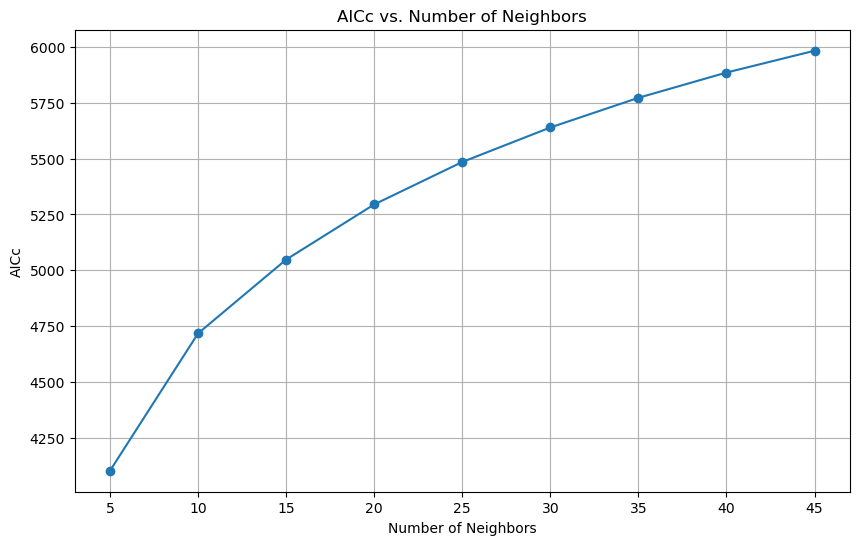

In [10]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

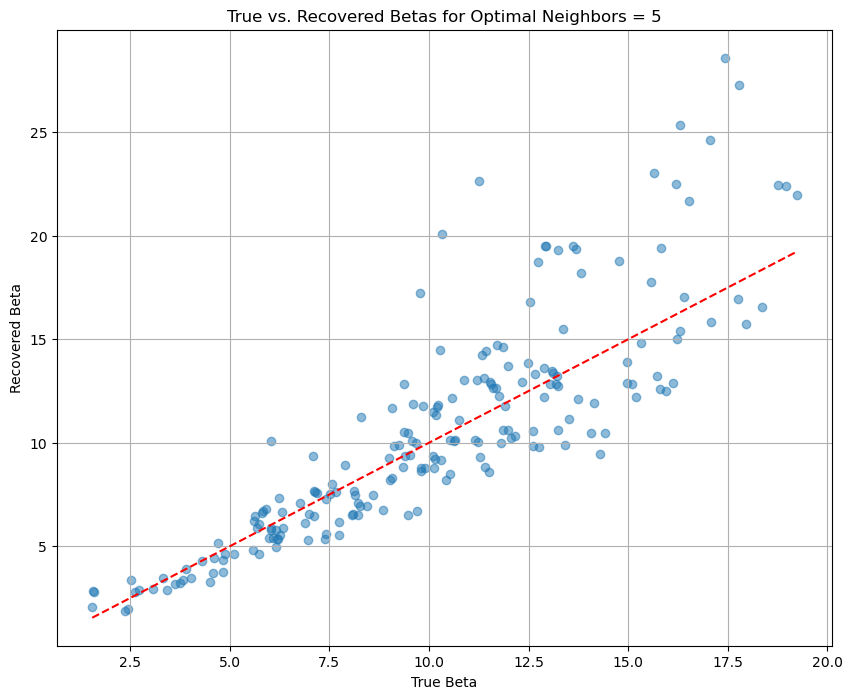

In [11]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()